# Tau PT Regression Notebook

In this notebook we will implement a NN to regress the tau's transverse momentum.

In [2]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/pt_regress_v1.h5'

2023-06-26 11:18:59.732667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 11:19:00.980488: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-26 11:19:01.234279: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-26 11:19:01.234302: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [101]:
# #You only need to run this once
# def create_training_data(dir_path, test_index=400000):
#     '''
#     test_index: 400000 
#     All the data before test_index are used for training. And all the data after it is used for testing.
#     '''
    
#     #Might have to change the version for other ntuple files
#     data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    
#     inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#     print(inputs)
#     truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[:test_index]
#     reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#     eta = data['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#     selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_train = np.nan_to_num(np.asarray(inputs[selection]))
#     y_train = np.asarray(truth_pt[selection]/reco_pt[selection])
    
#     X_train[abs(X_train) > 1e+9] = 0.

#     np.save(dir_path+"/X_train.npy", X_train)
#     np.save(dir_path+"/y_train.npy", y_train)

In [102]:
# create_training_data("../../ntuples/Jan_25_2023")

In [103]:
# X_train = np.load("../../ntuples/Jan_25_2023/X_train.npy")
# y_train = np.load("../../ntuples/Jan_25_2023/y_train.npy")
# print(X_train.shape[1:])
# print(len(y_train))

In [118]:
# def create_train_test_data(dir_path, test_index=400000, train = True):
        
#     #Might have to change the version for other ntuple files
#     sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
#     bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
#     qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
#     if train:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
#     else:
#         sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
#         qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

#         truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
#         truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
#         reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
#         deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
#         eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
#         selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
#         y_sig_pT = truth_pt_sig[selection_sig]

#         reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
#     selection_bkg = reco_pt_bkg > 20.
#     y_bkg_pT = truth_pt_bkg[selection_bkg]
#     print("b")
#     print(len(y_bkg_pT))
#     reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
#     selection_qcd = reco_pt_qcd > 20.
#     y_qcd_pT = truth_pt_qcd[selection_qcd]
        
#     #Inputs: pt, eta, phi, particle id(one hot encoded)
#     X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
#     y_sig = np.full(X_sig.shape[0], 1.)
#     sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
#     X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
#     y_bkg = np.full(X_bkg.shape[0], 0.)
#     bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
#     X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
#     y_qcd = np.full(X_qcd.shape[0], 0.)
#     qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
#     background_pt = np.concatenate([bkg_pt, qcd_pt])
#     print(y_sig, y_bkg, y_qcd)
#     X_train = np.concatenate([X_sig, X_bkg, X_qcd])
#     y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
#     MinBias_pT_1 = [1 for i in y_bkg_pT]
#     print(MinBias_pT_1)
#     qcd_pT_1 = [1 for i in y_qcd_pT]
# #     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
#     pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
#     X_train[abs(X_train) > 1e+4] = 0.
    
#     assert not np.any(np.isnan(X_train))
#     assert not np.any(np.isnan(y_train_jetID))
#     assert not np.any(np.isnan(y_train_pT))
    
#     return X_train, y_train_jetID, y_train_pT

# X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
# X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
# X_train = X_train_jetID
# y_train = y_train_pT_regress
# X_test = X_test_jetID
# y_test = y_test_pT_regress
# print(X_train_jetID)
# print(len(y_train_pT_regress))

b
38934
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

b
27752
[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 3.7000e+01  0.0000e+00  3.1250e-02 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 9.8000e+01 -1.5625e-02  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.2500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
282390


In [354]:
# lower the number of injections of MinBias to get rid of the bias torwards lower pT predictions

import random

def create_train_test_data(dir_path, test_index=400000, train = True):
        
    #Might have to change the version for other ntuple files
    sig = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    bkg = uproot4.open(dir_path+"/test_bkg_v12_emseed.root")
    qcd = uproot4.open(dir_path+"/test_qcd_v12_emseed.root")
    
    if train:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[:test_index]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[:test_index])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())

        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[:test_index]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[:test_index]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[:test_index]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[:test_index]
    else:
        sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        bkg_input = bkg['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
        qcd_input = qcd['ntuplePupSingle']['tree']['m_inputs'].array()

        truth_pt_sig = np.asarray(sig['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_bkg = np.asarray(bkg['ntuplePupSingle']['tree']['genpt1'].array()[test_index:])
        truth_pt_qcd = np.asarray(qcd['ntuplePupSingle']['tree']['genpt1'].array())
        reco_pt_sig = sig['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
        eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]
        selection_sig = (reco_pt_sig > 0.) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)
        y_sig_pT = truth_pt_sig[selection_sig]

        reco_pt_bkg = bkg['ntuplePupSingle']['tree']['pt'].array()[test_index:]
        
    
    selection_bkg = reco_pt_bkg > 10
    y_bkg_pT = truth_pt_bkg[selection_bkg]
    reco_pt_qcd = qcd['ntuplePupSingle']['tree']['pt'].array()
    selection_qcd = reco_pt_qcd > 10
    y_qcd_pT = truth_pt_qcd[selection_qcd]
        
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X_sig = np.nan_to_num(np.asarray(sig_input[selection_sig]))
    y_sig = np.full(X_sig.shape[0], 1.)
    sig_pt = np.asarray(reco_pt_sig[selection_sig])
    
    X_bkg = np.nan_to_num(np.asarray(bkg_input)[selection_bkg])
    y_bkg = np.full(X_bkg.shape[0], 0.)
    bkg_pt = np.asarray(reco_pt_bkg[selection_bkg])
    
    X_qcd = np.nan_to_num(np.asarray(qcd_input)[selection_qcd])
    y_qcd = np.full(X_qcd.shape[0], 0.)
    qcd_pt = np.asarray(reco_pt_qcd[selection_qcd])
    
    background_pt = np.concatenate([bkg_pt, qcd_pt])
    
    print(y_sig, y_bkg, y_qcd)
    
    if train:
        X_bkg = list(X_bkg)
        y_bkg = list(y_bkg)
        y_bkg_pT = list(y_bkg_pT)
        percent = 0.6
        for _ in range(int(percent*len(X_bkg))):
            n = len(X_bkg)
            random_ind = random.randint(0, n - 1)
            del X_bkg[random_ind]
            del y_bkg[random_ind]
            del y_bkg_pT[random_ind]
        X_bkg = np.asarray(X_bkg)
        y_bkg = np.asarray(y_bkg)
        y_bkg_pT = np.asarray(y_bkg_pT)
        
        X_qcd = list(X_qcd)
        y_qcd = list(y_qcd)
        y_qcd_pT = list(y_qcd_pT)
        for _ in range(int(percent*len(X_qcd))):
            n = len(X_qcd)
            random_ind = random.randint(0, n - 1)
            del X_qcd[random_ind]
            del y_qcd[random_ind]
            del y_qcd_pT[random_ind]
        X_qcd = np.asarray(X_qcd)
        y_qcd = np.asarray(y_qcd)
        y_qcd_pT = np.asarray(y_qcd_pT)

    X_train = np.concatenate([X_sig, X_bkg, X_qcd])
    y_train_jetID = np.concatenate([y_sig, y_bkg, y_qcd])
    MinBias_pT_1 = [1 for i in y_bkg_pT]
    qcd_pT_1 = [1 for i in y_qcd_pT]
#     y_train_pT = np.concatenate([y_sig_pT / sig_pt, y_bkg_pT / bkg_pT, y_qcd_pT / qcd_pt])
    y_train_pT = np.concatenate([y_sig_pT / sig_pt, MinBias_pT_1, qcd_pT_1])
    pt_array = np.concatenate([sig_pt, bkg_pt, qcd_pt])
    
    X_train[abs(X_train) > 1e+4] = 0.
    
    assert not np.any(np.isnan(X_train))
    assert not np.any(np.isnan(y_train_jetID))
    assert not np.any(np.isnan(y_train_pT))
    
    return X_train, y_train_jetID, y_train_pT

X_train_jetID, y_train_jetID,y_train_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=True)
X_test_jetID, y_test_jetID, y_test_pT_regress = create_train_test_data("../../ntuples/Jan_25_2023", train=False)
X_train = X_train_jetID
y_train = y_train_pT_regress
X_test = X_test_jetID
y_test = y_test_pT_regress

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
160751
160751
160751
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[1. 1. 1. ... 1. 1. 1.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[[ 8.9500e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 2.8750e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 5.1000e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 ...
 [ 3.7000e+01  0.0000e+00  3.1250e-02 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 9.8000e+01 -1.5625e-02  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.4250e+01  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
   0.0000e+00]]
241180


## Model

In [355]:
# inputs = tf.keras.layers.Input(shape=(80,), name='input')
# inputs = tf.expand_dims(inputs, axis=-1)

# main_branch = tf.keras.layers.Conv1D(25, kernel_size = 5)(inputs)
# main_branch = tf.keras.layers.Dense(25, activation = "LeakyReLU")(main_branch)
# main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
# main_branch = tf.keras.layers.Dense(15, activation = "LeakyReLU")(main_branch)
# main_branch = tf.keras.layers.Dense(10, activation = "LeakyReLU")(main_branch)


# output_branch = tf.keras.layers.Dense(1, name='pT_output')(main_branch)

# model = tf.keras.Model(inputs = inputs, outputs = output_branch)



model = Sequential()

model.add(tf.keras.Input(shape=(80,)))

#model.add(Conv1D(32, kernel_size = 5))


model.add(Dense(25,
                #input_shape=(X_train.shape[1:]),
                activation= 'LeakyReLU'))

model.add(Dense(25,
                #input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))
model.add(Dense(15,
                #input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(15,
                #input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(10,
                #input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(1))

In [356]:
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 25)                2025      
                                                                 
 dense_163 (Dense)           (None, 25)                650       
                                                                 
 dense_164 (Dense)           (None, 15)                390       
                                                                 
 dense_165 (Dense)           (None, 15)                240       
                                                                 
 dense_166 (Dense)           (None, 10)                160       
                                                                 
 dense_167 (Dense)           (None, 1)                 11        
                                                                 
Total params: 3,476
Trainable params: 3,476
Non-train

In [357]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=256,
                    verbose=2,
                    validation_split=0.2, 
                    callbacks = [callback])

Epoch 1/30
754/754 - 2s - loss: 0.2168 - val_loss: 0.0539 - 2s/epoch - 2ms/step
Epoch 2/30
754/754 - 1s - loss: 0.1549 - val_loss: 0.0424 - 733ms/epoch - 973us/step
Epoch 3/30
754/754 - 1s - loss: 0.1468 - val_loss: 0.0425 - 725ms/epoch - 962us/step
Epoch 4/30
754/754 - 1s - loss: 0.1429 - val_loss: 0.0384 - 724ms/epoch - 960us/step
Epoch 5/30
754/754 - 1s - loss: 0.1399 - val_loss: 0.0357 - 726ms/epoch - 963us/step
Epoch 6/30
754/754 - 1s - loss: 0.1379 - val_loss: 0.0507 - 733ms/epoch - 972us/step
Epoch 7/30
754/754 - 1s - loss: 0.1367 - val_loss: 0.0457 - 789ms/epoch - 1ms/step
Epoch 8/30
754/754 - 1s - loss: 0.1358 - val_loss: 0.0617 - 826ms/epoch - 1ms/step
Epoch 9/30
754/754 - 1s - loss: 0.1364 - val_loss: 0.0474 - 993ms/epoch - 1ms/step
Epoch 10/30
754/754 - 1s - loss: 0.1348 - val_loss: 0.0414 - 1s/epoch - 1ms/step
Epoch 10: early stopping


In [358]:
#Save the model
model.save(model_name)

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

In [359]:
#Load the pts and then plot the actual distributions

In [360]:
def load_and_predict_test(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test).flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

2043/2043 [==============================] - 2s 819us/step


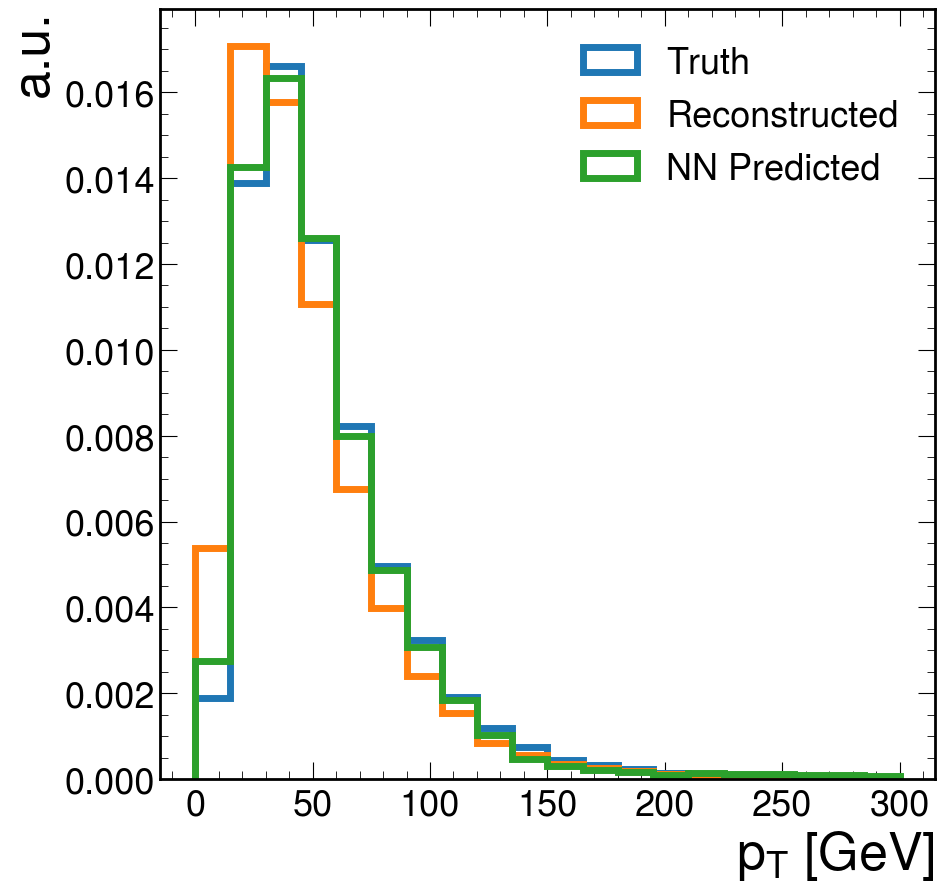

In [361]:
load_and_predict_test("../../ntuples/Jan_25_2023", model)

In [362]:
# Looking nice!! 

In [363]:
def bob(dir_path, model, test_index=400000):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()[test_index:]
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()[test_index:]
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()[test_index:]
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()[test_index:]
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()[test_index:]

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(truth_pt[selection])
    reco_pt_selected = np.asarray(reco_pt[selection])
    
    X_test = np.asarray(inputs[selection])
    y_pred = model.predict(X_test).flatten()
    pred_pt = np.multiply(reco_pt_selected, y_pred)
    
    residual = pred_pt - truth_pt_selected
    print(min(residual))
    print(max(residual))
    plot_bins = 200
    plot_range = (-125, 75)
    p_guess=[10, 0, 0.01]
    plt.hist(residual,
         bins = plot_bins,
         range = plot_range,
         density = True)
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(plot_range[0], plot_range[1], plot_bins+1)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    
    data_entries, _ = np.histogram(residual, bins=bins,
                                   range = plot_range,
                                   density = True)
    
    mask = data_entries!=0
    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function,
                           xdata=binscenters[mask],
                           ydata=data_entries[mask],
                           sigma = np.sqrt(data_entries[mask]),
                           absolute_sigma = False)
    
    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print("Error for parameter esimations: ", perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    
    #Plot fitted gaussian
    plt.plot(bins,
             fit_function(bins, *popt),
             "r-",
             linewidth=4,
             label='Best fit')

    plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
    plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%abs(popt[2]))
    
    plt.xlabel("$p_T^{corrected} - p_T^{gen}$ [GeV]", fontsize = 27)
    plt.ylabel('Normalized counts')

    plt.legend()


2043/2043 [==============================] - 2s 979us/step
-586.95703
5062.1035
Error for parameter esimations:  [0.00186418 0.26752736 0.2363153 ]
Standard deviation (fit) is 7.93677424271721
Mean (fit) is -0.5771407147950979


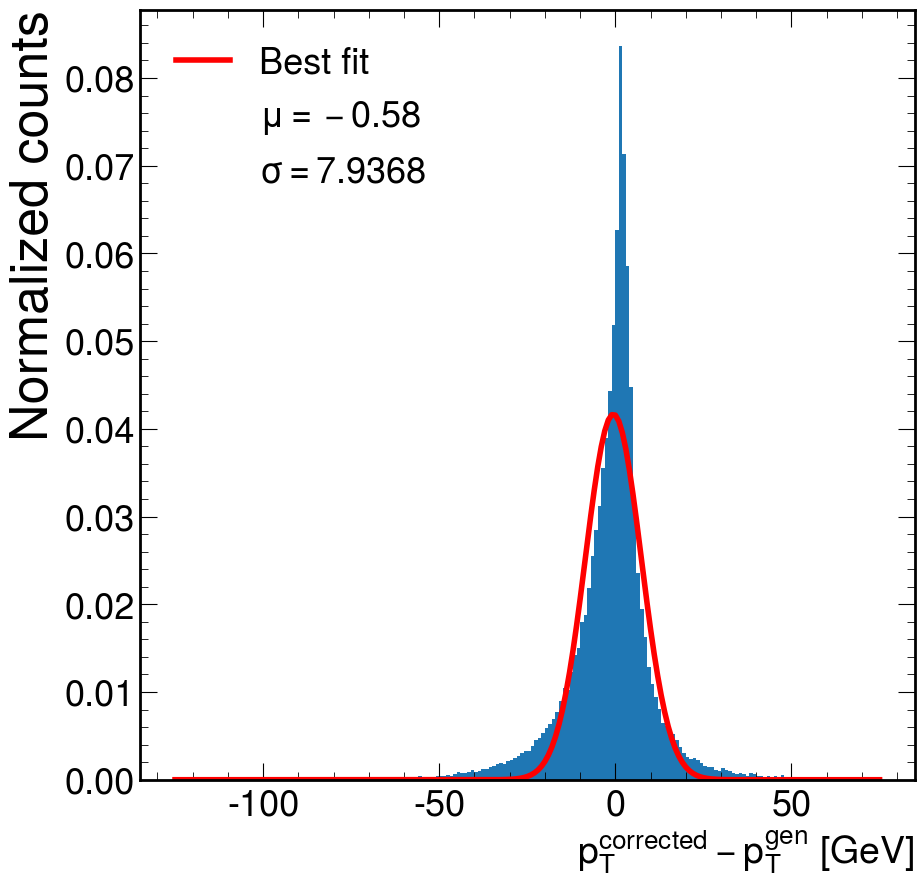

In [364]:
bob("../../ntuples/Jan_25_2023", model)

In [365]:
NormalModel = load_model('../../models/Feb_4_2023_JetMetTalk_v1_pTShape_EMSeed.h5')
    
y_pred_mono = model(X_test)
fpr_mono, tpr_mono, _ = roc_curve(y_test_jetID, y_pred_mono)
auc_score_mono = round(auc(fpr_mono, tpr_mono),2)

y_pred_normal = NormalModel.predict(X_test)
fpr_normal, tpr_normal, _ = roc_curve(y_test_jetID,y_pred_normal)
auc_score_normal = round(auc(fpr_normal, tpr_normal),2)

11371/11371 [==============================] - 9s 757us/step


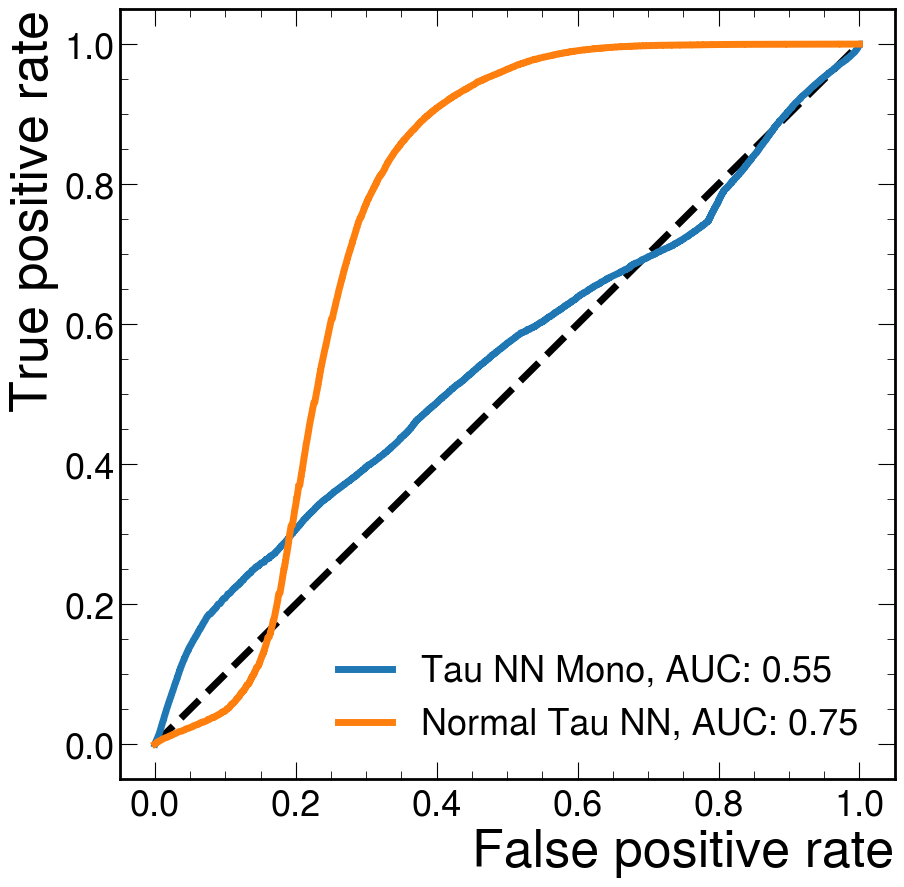

In [366]:
#Create plot for ROC
plt.figure(1)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr_mono, tpr_mono, label = 'Tau NN Mono, AUC: {}'.format(auc_score_mono))
plt.plot(fpr_normal, tpr_normal, label = 'Normal Tau NN, AUC: {}'.format(auc_score_normal))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()